<a href="https://colab.research.google.com/github/adibayaseen/HKRCPI/blob/main/code/Final_RankofFirstPositiveProtein_SVM_nr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()#install_miniconda()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In [ ]:
!conda install -c bioconda cd-hit

Solving environment: - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cd-hit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    cd-hit-4.8.1               |       h2e03b76_5         251 KB  bioconda
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    conda-4.11.0               |   py37h89c1867_0        16.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        17.4 MB

The following NEW packages will be INSTALLED:

  cd-hit             bioconda/linux-64::cd-hit-4.8.1-h2e03b76_5

The following packages will be UPDATED:

  ca-certificates                      2020.12.5-ha878542_0 --> 2021.10.8-ha878542_0
  certifi      

In [ ]:
!pip install biopython

     |████████████████████████████████| 2.3 MB 5.4 MB/s 
     |████████████████████████████████| 15.7 MB 35.9 MB/s 


In [ ]:
!mamba install -c conda-forge rdkit

Streaming output truncated to the last 5000 lines.
libcblas                 [] (00m:00s) Waiting...
fontconfig               [] (00m:00s) Waiting...
libpng                   [] (00m:00s) Waiting...
python-dateutil          [] (00m:00s) Waiting...
openjpeg                 [] (00m:00s) Waiting...
xorg-xextproto           [] (00m:00s) Waiting...
xorg-libice              [] (00m:00s) Waiting...
greenlet                 [] (00m:00s) Waiting...
libxcb                   [] (00m:00s) Validating...
Finished libblas                              (00m:01s)              12 KB     27 KB/s
libstdcxx-ng             [] (00m:01s) Waiting...
gettext                  [] (00m:01s) Waiting...
libtiff                  [] (00m:01s) Decompressing...
libglib                  [] (00m:01s) Waiting...
olefile                  [] (00m:01s) Waiting...
libwebp-base             [] (00m:01s) Waiting...
libopenblas              [] (00m:01s) Waiting...
pthread-stubs            [] (00m:01s) Waiting...
pillow              

In [ ]:
from rdkit import Chem

ImportError: ignored

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 10 20:01:32 2021
@author: fayya
"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
#rdkit.Avalon.pyAvalonTools.GetAvalonCountFP((object)mol[, (int)nBits=512[, (bool)isQuery=False[, (int)bitFlags=15761407]]])
#from rdkit.Avalon import pyAvalonTools as pat
def getFP(s,r = 3,nBits = 1024):        
    compound = Chem.MolFromSmiles(s.strip())
    fp = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits = nBits)
    #fp = pat.GetAvalonCountFP(compound,nBits=nBits)
    m = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, m)     
    return m
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import random
import numpy as np
def NRKFold(E,pc,K = 5, shuffle=True):
    """
    Generate non-redundant K-folds so that no two folds contain proteins
    belonging to the same cluster and the number of examples are (approx)
    equal in all folds. Implements the greedy number partitioning method
    https://en.wikipedia.org/wiki/Greedy_number_partitioning
    >>> NRKFold(['p1','p2','p3','p4','p5','p6','p1'],{'p1':1,'p2':2,'p3':1,'p4':2,'p5':3,'p6':3},K=2, shuffle = False)
    Here we have 7 examples involving 6 proteins p1-p6 such that proteins
    p1,p3,p5 form one cluster whereas p2,p4,p6 form another cluster
    This results in division into two folds as [[0, 2, 6], [1, 3, 4, 5]]
    Note that examples 0,2,6 comprising fold-1 with proteins p1 and p2 are 
    from the first cluster whereas the remaining examples are from other clusters
    Parameters
    ----------
    E : TYPE List (length equal to number of examples)
        DESCRIPTION. Protein id of protein involved in each example
    pc : TYPE dictionary 
        DESCRIPTION. Cluster assignment of each protein
    K : TYPE, optional Integer
        DESCRIPTION. Number of folds The default is 5.
    shuffle: TYPE, Boolean
        cluster to fold assignments are different across different runs
    Returns
    -------
    F : TYPE list of lists
        DESCRIPTION. Indices of examples in E in each fold
    """
    e = [pc[str(x)] for x in E] #cluster indices of all proteins in the examples
    c2idx={} #indices of examples of each cluster in e
    for i,x in enumerate(e):
        try: 
            c2idx[x].append(i)
        except:
            c2idx[x]=[i]    
    ce = dict([(c,len(c2idx[c])) for c in c2idx]) #counts of examples of different clusters    
    cF = [0]*K; #counts of examples in each fold
    CF = [[] for _ in range(K)]; #clusters in each fold
    F = [[] for _ in range(K)];#indices of examples in each fold
    keys = list(ce.keys())
    if shuffle:
        random.shuffle(keys)
    for k in keys:
        v = ce[k]
        idx = np.argmin(cF)
        cF[idx]+=v
        CF[idx].append(k) #add cluster to fold
        F[idx].extend(c2idx[k])
    return F
import os
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
def processCDHIT(L,cthresh,ofile="out.cdhit"):#=0.8
    """   
    Generate CD-HIT clustering
    Runs CD-HIT and creates a temporary file which is not deleted automatically
    Parameters
    ----------
    L : TYPE Fasta file string OR List of protein sequences OR  SeqRecord
        DESCRIPTION.
    cthresh : TYPE, optional
        DESCRIPTION. Cutoff threshold The default is 0.8.
    ofile : TYPE, optional
        DESCRIPTION. The default is "out.cdhit".
    Returns
    -------
    cc : TYPE Dictionary with cluster id  as key and list of protein ids in each cluster
        DESCRIPTION. 
    pc: TYPE Dictionary with protein id string as key and cluster id as value
        DESCRIPTION. 
    """
    if type(L)==type(""):
        ifile = L
    else:
        if type(L[0]==type("")):
            L = [SeqRecord(Seq(p),id=str(i)) for i,p in enumerate(L)]
        ifile = ofile+"_temp.fasta"
        with open(ifile, "w") as output_handle:
            SeqIO.write(L, output_handle, "fasta") 
    
    cmd = "cd-hit -i "+ifile+" -d 0 -o "+ofile+" -c "+str(cthresh)+" -n 3  -G 1 -g 1 -b 20 -l 10 -s 0.0 -aL 0.0 -aS 0.0 -T 4 -M 32000"   
    os.system(cmd)
    with open(ofile+".clstr","r") as fh:
        clusters = fh.readlines()
    cc = {}
    for x in clusters:
        xs = x.split()
        if xs[0]=='>Cluster':
            ccid = int(xs[1])
            cc[ccid]=[]
        else:
            pid = xs[2][1:].split('...')[0]
            cc[ccid].append(pid)  
    pc = {}
    for k,v in cc.items():
        for vi in v:
            pc[vi]=k
    return cc,pc

def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')


from Bio import SeqIO
from Bio.SeqIO import FastaIO
from itertools import product
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import math
def twomerFromSeq(s):
    k=2
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values()  )           #[ 0,0,0,0,0,0,0]
        key=list(count.keys()     )           #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
def threemerFromSeq(s):
    k=3
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values())              #[ 0,0,0,0,0,0,0]
        key=list(count.keys() )              #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
def prot_feats_seq(seq):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f=[]
    X = ProteinAnalysis(str(seq))
    X.molecular_weight() #throws an error if 'X' in sequence. we skip such sequences
    p=X.get_amino_acids_percent()
    dp=[]
    for a in aa:
        dp.append(p[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    tm=np.array(twomerFromSeq(str(seq)))
    tm=normalize(np.atleast_2d(tm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(tm[0])
    thm=np.array(threemerFromSeq(str(seq)))
    thm=normalize(np.atleast_2d(thm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(thm[0])
    return np.array(f)
def DataWrite(Cseq,Pseq,Y, filename):
  path='/content/drive/MyDrive/CPI_Data/'
  filename=open(path+filename+'.txt','w', encoding="utf-8")
  for data in range(len(Cseq)):
    filename.write((Cseq[data]+' '+Pseq[data]+' '+str(Y[data])+"\n"))
def Features_PredictorBindingDB(filename):
  path='/content/drive/MyDrive/CPI_Data/'
  #with open(path+'2p2i_TargetvsNonTargetchain_human.txt') as f:#New_Unique_data.txt') as f:#
  with open(path+filename) as f:
    #with open('./data.txt') as f:#../../celegans/original
    D = f.readlines()
  C=[];P=[];Y=[];Cseq=[];Pseq=[]
  Ids=[];Ligands=[];Complexs=[];Chains=[];
  for d in tqdm(D):
      #Id,Ligand,Complex,Chain,c,p,y = d.split()
      c,p,y = d.split()
      #id,c,p,y = d.split()
      try:
          xc = getFP(c)
          xp = prot_feats_seq(p)
      except Exception as e:
          print(e)
          continue
      Cseq.append(c)
      Pseq.append(p)
      C.append(xc)
      P.append(xp)
      Y.append(float(y))
      ####
      #Ids.append(Id);Ligands.append(Ligand);Complexs.append(Complex);Chains.append(Chain);
  Y = np.array(Y);
  C = np.array(C);
  P = np.array(P);
  return P,C,Y
def Features_Predictor(filename):
  path='/content/drive/MyDrive/CPI_Data/'
  #with open(path+'2p2i_TargetvsNonTargetchain_human.txt') as f:#New_Unique_data.txt') as f:#
  with open(path+filename) as f:
    #with open('./data.txt') as f:#../../celegans/original
    D = f.readlines()
  C=[];P=[];Y=[];Cseq=[];Pseq=[]
  Ids=[];Ligands=[];Complexs=[];Chains=[];
  for d in tqdm(D):
      Id,Ligand,Complex,Chain,c,p,y = d.split()
      #c,p,y = d.split()
      #id,c,p,y = d.split()
      try:
          xc = getFP(c)
          xp = prot_feats_seq(p)
      except Exception as e:
          print(e)
          continue
      Cseq.append(c)
      Pseq.append(p)
      C.append(xc)
      P.append(xp)
      Y.append(2*float(y)-1)
      ####
      Ids.append(Id);Ligands.append(Ligand);Complexs.append(Complex);Chains.append(Chain);
  Y = np.array(Y);
  C = np.array(C);
  P = np.array(P);
  return P,C,Y
def Calculate_RFPP(z,Targetlabels):
  RPP=[]
  index_P=np.argsort(z)
  n=len(Targetlabels)
  sorted_index=index_P[::-1][:n]
  sorted_score=z[index_P[::-1][:n]]
  sorted_Targetlabels=Targetlabels[sorted_index]
  ###
  RPP.append(np.where(sorted_Targetlabels==1))
  RFPP=np.min(RPP)+1
  return RFPP 
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics.pairwise import rbf_kernel as kernel #sigmoid_kernel,rbf_kernel,linear_kernel
from sklearn.model_selection import StratifiedKFold, KFold
import random
if __name__=='__main__':
    NegtiveRatio='1'
    path='/content/drive/MyDrive/CPI_Data/'
    #with open(path+'Orignal_CPI_data.txt') as f:#6725
    with open(path+'pos2negtiveRatio'+str( NegtiveRatio)+'_Random.txt') as f:
    #with open('./data.txt') as f:#../../celegans/original
        D = f.readlines()
    """
    path='/content/drive/MyDrive/CPI_Data/'
    with open(path+'Orignal_CPI_data.txt') as f:#New_Unique_data.txt') as f:#
    #with open('./data.txt') as f:#../../celegans/original
        D = f.readlines()
    """
    Alpha_threshold='Random'
    C=[];P=[];Y=[];Cseq=[];Pseq=[]
    for d in tqdm(D):
        c,p,y = d.split()
        #id,c,p,y = d.split()
        try:
            xc = getFP(c)
            xp = prot_feats_seq(p)
        except Exception as e:
            print(e)
            continue
        Cseq.append(c)
        Pseq.append(p)
        C.append(xc)
        P.append(xp)
        Y.append(2*float(y)-1)
    Y = np.array(Y)
    C = np.array(C);
    P = np.array(P);
    
#%% Generating negative examples  
    regenerate =  False#
    if regenerate:
        Pset = list(set(Pseq)) #set of protein sequences
        pidx = list(range(len(Pset))) 
        Pdict = dict(zip(Pset, pidx)) #seq->index
        Cset = list(set(Cseq)) #set of compound sequences
        cidx = list(range(len(Cset)))#
        Cdict = dict(zip(Cset, cidx)) #str->index
        #1/0
        Epairs = np.array([(Pdict[p],Cdict[c]) for (p,c) in zip(Pseq,Cseq)]) #dict of pairs
        pos,negs = Epairs[Y==1,:],Epairs[Y!=1,:] 
        #if the negs are to be sampled such that the both the protein and compound occur in the positive set as well
        pidx,cidx = list(set(pos[:,0])),list(set(pos[:,1])) #replaced with only positive
        #pos, negs = list(map(tuple,pos.tolist())),list(map(tuple,negs.tolist())) #
        #below - remove 100% redundant positive and negative examples -- original redundant examples are not removed otherwise
        pos, negs = list(set(map(tuple,pos.tolist()))),list(set(map(tuple,negs.tolist())))
        NegtiveRatio=7
        NN =NegtiveRatio*len(pos)#len(negs) #
        negs = [] #comment to use the set of original negatives
        Lnegs = len(negs)
        ######## Dissimilarity Criteria for negtive examples
        
        Pos_Pseq=np.array([s[0] for s in pos])#Orignal
        #Pos_PFeatures = np.array([prot_feats_seq(Pset[s[0]]) for s in pos])#orignal
        #Pos_Pseq=np.array([s[0] for s in pos])
        #Pos_Pseq=list (set (Pos_Pseq))#should pick only unique protein 
        Pos_PFeatures = np.array([prot_feats_seq(Pset[s]) for s in Pos_Pseq])#should pick only unique protein 
        Pos_Cseq=np.array([s[1] for s in pos])#orignal
        #Pos_Cseq=list (set (Pos_Cseq))#should pick only unique Compounds 
        #Pos_CFeatures = np.array([getFP(Cset[s[1]]) for s in pos])#orignal
        Pos_CFeatures = np.array([getFP(Cset[s]) for s in Pos_Cseq])#should pick only unique compounds
       
        #######
        Pos_Pscaler = StandardScaler().fit(Pos_PFeatures )
        Pos_Cscaler = StandardScaler().fit(Pos_CFeatures)
        Pos_Ptr,Pos_Ctr = Pos_Pscaler.transform(Pos_PFeatures), Pos_Cscaler.transform(Pos_CFeatures)
        #####
        Kpp = kernel(Pos_Ptr)
        Kcp = kernel(Pos_Ctr)
        Kpp_dict=dict(zip(Pos_Pseq,Kpp))
        Kcp_dict=dict(zip(Pos_Cseq,Kcp))
        ######
        Alpha_threshold=0.5#'Random'#0.5#
        while len(negs)<NN:
          possible = (random.choice(pidx),random.choice(cidx))#(pidx[np.random.randint(0,len(ppos))],cidx[np.random.randint(0,len(cpos))])
          index_P=np.argmax(Kpp_dict[possible[0]])
          new_Spp=np.delete(Kpp[index_P],index_P)
          index_C=np.argmax(Kcp_dict[possible[1]])
          new_Scp=np.delete(Kcp[index_C],index_C)
          Alpha=np.max(new_Spp)*np.max(new_Scp)
          if possible not in pos and possible not in negs and Alpha<Alpha_threshold:# and Alpha_threshold!='Random':
              negs.append(possible)        
        print('Added Negatives',len(negs)-Lnegs)
        iPdict = {v: k for k, v in Pdict.items()}
        iCdict = {v: k for k, v in Cdict.items()}
        
        C=[];P=[];Y=[];Cseq=[];Pseq=[]
        for i,(p,c) in tqdm(enumerate(pos+negs)):
            p = iPdict[p]
            c = iCdict[c]
            try:
                xc = getFP(c)
                xp = prot_feats_seq(p)
            except Exception as e:
                print(e)
                continue
            Cseq.append(c)
            Pseq.append(p)
            C.append(xc)
            P.append(xp)
            Y.append(2*(i<len(pos))-1)
        
#%%
    Y = np.array(Y)
    C = np.array(C);
    P = np.array(P);
    ####
    #filename="pos2negtiveRatio"+str (NegtiveRatio)+"_Alpha_threshold_"+str (Alpha_threshold)
    #filename="pos2negtiveRatio"+str (NegtiveRatio)+"_"+str (Alpha_threshold)
    #DataWrite(Cseq,Pseq,Y, filename)
    import itertools
    Pset = list(set(Pseq)) #set of protein sequences
    pidx = list(range(len(Pset))) 
    Pdict = dict(zip(Pset, pidx)) #seq->index
    Cset = list(set(Cseq)) #set of compound sequences
    cidx = list(range(len(Cset)))#
    Cdict = dict(zip(Cset, cidx)) #str->index
    Epairs = np.array([(Pdict[p],Cdict[c]) for (p,c) in zip(Pseq,Cseq)]) #dict of pairs
#%% 
    cc,pc = processCDHIT(Pset,cthresh = 0.9) 
    
    E = list(Epairs[:,0]) #protein id of examples
    F = NRKFold(E,pc,K=5,shuffle=True)   
    
#%%        
    gp = gc = None
    skf = KFold(n_splits=5,shuffle=True)
    skf = StratifiedKFold(n_splits=5,shuffle=True)        
    F=[list(test_index) for (train_index, test_index) in skf.split(P, Y)] 
    F = NRKFold(E,pc,K=5,shuffle=True) 
    Z = []; Yo = []; A = [];Yp=[]
    # for train_index, test_index in tqdm(skf.split(P, Y)):
    AUC_ROC_final=[];Precision_final=[];Recall_final=[];Avg_P_final=[];
    #AUC_ROC_External=[];Precision_External=[];Recall_External=[];Avg_P_External=[];
    AUC_ROC_External=[]
    ###For RFPP
    pos,negs = Epairs[Y==1,:],Epairs[Y!=1,:] 
    Pos_Cseq=np.array([s[1] for s in pos])#orignal
    Pos_Cseq=list (set (Pos_Cseq))#should pick only unique Compounds 
    #Pos_CFeatures = np.array([getFP(Cset[s[1]]) for s in pos])#orignal
    Pos_CFeatures = np.array([getFP(Cset[s]) for s in Pos_Cseq])#should pick only unique compounds
    #Unique_Compounds_Features_duct=dict (zip(Pos_Cseq,Pos_CFeatures))
    ####P2C_dict is the protein paired with all compounds in positive set
    from collections import defaultdict
    P2C_dict=defaultdict(list)
    for (key, value) in pos:
      #key,value=Pset[key],Cset[value]
      if key not in P2C_dict:
        P2C_dict[key]=[value]
      else:
        P2C_dict[key]=np.append(P2C_dict.get(key, ()) , value)
    #######
    RFPP_all=[]
    perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]#99
    for f in tqdm(range(len(F))):
      train_index = list(itertools.chain.from_iterable(F[:f]+F[f+1:]))
      test_index = F[f]
      #show number of proteins shared between train and test
      print(len(set([E[x] for x in train_index]).intersection([E[x] for x in test_index])))        
      y_train, y_test = Y[train_index], Y[test_index] 
      Ptr,Ctr = P[train_index,:],C[train_index,:]
      Pscaler = StandardScaler().fit(Ptr)
      Cscaler = StandardScaler().fit(Ctr)
      Ptr,Ctr = Pscaler.transform(Ptr), Cscaler.transform(Ctr)
      
      Kp = kernel(Ptr)
      Kc = kernel(Ctr)
      Ktr = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
      
      clf = SVC(C = 1.0, kernel = 'precomputed',class_weight='balanced')
      clf.fit(Ktr,y_train)
      ####Rank of First positive protein
      test_neg=np.where(y_test[y_test==-1])
      test_pos=np.where(y_test[y_test==1])
      ####
      Unique_PFeature_dict={}
      for s in test_pos[0]:
        #test_Pseqindex.append(Pdict[Pseq[test_pos[0][s]]])
        if Pdict[Pseq[test_pos[0][s]]] not in Unique_PFeature_dict:
          Unique_PFeature_dict[Pdict[Pseq[test_pos[0][s]]]]=P[test_pos[0][s]]
      test_Pseq_Uniqueindex=list (Unique_PFeature_dict.keys())
      ###loop
      for Pi_index in range(len(test_Pseq_Uniqueindex)):
        ####For one example Pi
        Pi=test_Pseq_Uniqueindex[Pi_index ]#pick one protein P index
        Pi_Feature=Unique_PFeature_dict[test_Pseq_Uniqueindex[Pi_index ]]#P features of that index
        #Pos_Cseq#pair with all unique compounds
        Ptt=np.array([Pi_Feature for i in range(len(Pos_Cseq))])#Copy same feature of protein equal to number of unique compounds
        Unique_Compounds_Features_dict=dict (zip(Pos_Cseq,Pos_CFeatures))#make new every time beacuse positive compounds deleted from orignal
        ######positve compounds 
        Actual_Compound=P2C_dict[Pi]#Actul_Compound paired with Pi
        Actual_Compound_Features=np.array([Unique_Compounds_Features_dict[c] for c in Actual_Compound])#Features of Actul_Compound paired with Pi
        for c in Actual_Compound:
          del Unique_Compounds_Features_dict[c]#delete positive examples
        Negative_Compound_Features=np.array([Unique_Compounds_Features_dict[c] for c in Unique_Compounds_Features_dict])#Negative examples features
        Ctt=np.vstack((Actual_Compound_Features,Negative_Compound_Features ))
        #####
        Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
        Kp = kernel(Ptt,Ptr)
        Kc = kernel(Ctt,Ctr)
        Ktt = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
        z = clf.decision_function(Ktt)
        ####labels
        poslabel=1*np.ones(len(Actual_Compound_Features))
        neglabel=-1*np.ones(len(Negative_Compound_Features))
        Targetlabels=np.append(poslabel,neglabel )
        #RFPP=Calculate_RFPP(z,Targetlabels)
        ###Calculate_RFPP(z,Targetlabels)#score,label return RFPP
        z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
        RFPP=Calculate_RFPP(z_random,Targetlabels)
        RFPP_all.append(RFPP)
    ####RFPP'
    Average_perntile=np.percentile(RFPP_all,perntile_values)
    #np.save(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
    #np.save(path+'Random_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)
    #np.save(path+'Random_SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)
    plt.figure()
    plt.plot(perntile_values,np.log10 (Average_perntile),color='r',marker='x',label=Alpha_threshold+'_NagtiveRatio_{0:.2f}'.format(int (NegtiveRatio)))
    plt.grid()
    plt.xlabel('Percentile')
    plt.ylabel('log10 RFPP')
    plt.title('RFPP of positive proteins in test with SuperDrug compounds')
    plt.legend()

  0%|          | 0/5 [00:00<?, ?it/s]

0


 20%|██        | 1/5 [04:04<16:19, 244.80s/it]

0


 40%|████      | 2/5 [07:48<11:37, 232.42s/it]

0


 60%|██████    | 3/5 [11:34<07:38, 229.31s/it]

0


 80%|████████  | 4/5 [15:55<04:01, 241.82s/it]

0


100%|██████████| 5/5 [19:57<00:00, 239.42s/it]


ValueError: ignored

<Figure size 432x288 with 0 Axes>

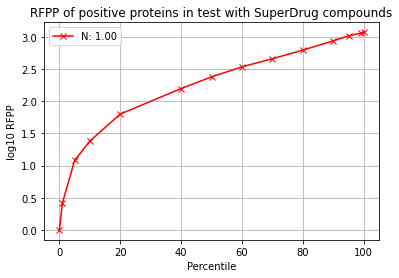

In [ ]:
plt.figure()
plt.plot(perntile_values,np.log10 (Average_perntile),color='r',marker='x',label='N: {0:.2f}'.format(int (NegtiveRatio)))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('log10 RFPP')
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
Average_perntile

array([1.00000e+00, 2.64000e+00, 1.20000e+01, 2.40000e+01, 6.30000e+01,
       1.57000e+02, 2.38000e+02, 3.41000e+02, 4.55800e+02, 6.20200e+02,
       8.65600e+02, 1.03180e+03, 1.13724e+03, 1.17400e+03])

In [ ]:
for p in perntile_values:
  perntile=[]
  for fold in range(len(RFPP_Folds)):
    perntile.append(np.percentile(RFPP_Folds[fold],p))
  perntile_list.append(perntile)
Average_perntile=np.mean(perntile_list, axis=1)

NameError: ignored

In [ ]:
len(Cset)

1179

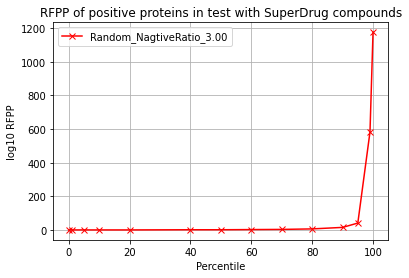

In [ ]:
plt.figure()
plt.plot(perntile_values,Average_perntile,color='r',marker='x',label=Alpha_threshold+'_NagtiveRatio_{0:.2f}'.format(NegtiveRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('log10 RFPP')
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
Average_perntile[:-3]

NameError: ignored

In [ ]:
Average_perntile

NameError: ignored

In [ ]:
####labels
poslabel=1*np.ones(len(Actual_Compound_Features))
neglabel=-1*np.ones(len(Negative_Compound_Features))
Targetlabels=np.append(poslabel,neglabel )
###Calculate_RFPP(z,Targetlabels)#score,label return RFPP
z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
#z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
RFPP=Calculate_RFPP(z,Targetlabels)

In [ ]:
RFPP=Calculate_RFPP(z_random,Targetlabels)

In [ ]:
RFPP

210

In [ ]:
P2C_dict[Pi]

array([ 997,   70,   32, 1047,  325,  866])

In [ ]:
Actual_Compound=P2C_dict[Pi]#Actul_Compound paired with Pi

In [ ]:
Actual_Compound

array([ 997,   70,   32, 1047,  325,  866])

In [ ]:
Unique_Compounds_Features_dict=dict (zip(Pos_Cseq,Pos_CFeatures))
Actual_Compound=P2C_dict[Pi]#Actul_Compound paired with Pi
Actual_Compound_Features=np.array([Unique_Compounds_Features_dict[c] for c in Actual_Compound])
for c in Actual_Compound:
  del Unique_Compounds_Features_dict[c]
Negative_Compound_Features=np.array([Unique_Compounds_Features_dict[c] for c in Unique_Compounds_Features_dict])
Ctt=np.vstack((Actual_Compound_Features,Negative_Compound_Features ))
poslabel=1*np.ones(len(Actual_Compound_Features))
neglabel=-1*np.ones(len(Negative_Compound_Featuress))
Targetlabels=np.append(poslabel,neglabel )
###Calculate_RFPP(z,Targetlabels)#score,label return RFPP
#z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
#z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
RFPP=Calculate_RFPP(z,Targetlabels)
#RFPP=Calculate_RFPP(z_random,Targetlabels)
RFPP_Folds.append(RFPP)

In [ ]:
len(Ctt)

1179

In [ ]:


RFPP_list=np.append(RFPP_list,RFPP_Folds)
####RFPP'
Average_perntile=np.percentile(RFPP_Folds,perntile_values)
np.save(path+'SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)

In [ ]:
Unique_Compounds_keys=list (Unique_Compounds_Features_dict.keys())

In [ ]:
for c in Actual_Compound:
  del Unique_Compounds_Features_dict[c]

In [ ]:
len(Unique_Compounds_Features_dict)

1173

In [ ]:
Negative_Compound_Features=[]
for c in Unique_Compounds_Features_dict:
  if c not in Actual_Compound:
    Negative_Compound_Features.append(Unique_Compounds_Features_dict[c])

In [ ]:
Unique_Compounds_Features_dict[c]

array([0, 1, 0, ..., 0, 0, 0], dtype=int8)

In [ ]:
len(Unique_Compounds_Features_dict)

1179

In [ ]:
len(Negative_Compound_Features)

1173

In [ ]:
Negative_Compound_Features

In [ ]:
len(Actual_Compound_Features)

6

In [ ]:
Actual_Compound_Features

In [ ]:
plt.figure()
plt.plot(perntile_values,Average_perntile,color='r',marker='x',label='Alpha_{0:.2f}_NRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))

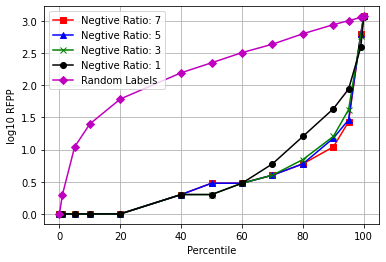

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
path='/content/drive/MyDrive/CPI_Data/'
perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]
#plt.set_yscale('log')
NegativeRatio=7
Average_perntile_Random7=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10(Average_perntile_Random7),color='r',marker='s',label='Negtive Ratio:{: .0f}'.format(NegativeRatio))
###
"""
Average_perntile_05=np.load(path+'Average_perntile_0.5_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_05,color='y',marker='d',label='5fold_Alpha_0.5_NegtiveRatio_{: .0f}'.format(NegativeRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()
###
1/0
"""
######
NegativeRatio=5
Average_perntile_Random5=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10(Average_perntile_Random5),color='b',marker='^',label='Negtive Ratio:{: .0f}'.format(NegativeRatio))
######
NegativeRatio=3
Average_perntile_Random3=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10(Average_perntile_Random3),color='g',marker='x',label='Negtive Ratio:{: .0f}'.format(NegativeRatio))
###
######
NegativeRatio=1
Average_perntile_Random1=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10(Average_perntile_Random1),color='k',marker='o',label='Negtive Ratio:{: .0f}'.format(NegativeRatio))
####
Random_Average_perntile_Random1=np.load(path+'Random_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10(Random_Average_perntile_Random1),color='m',marker='D',label='Random Labels')
####
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('log10 RFPP')
plt.legend()

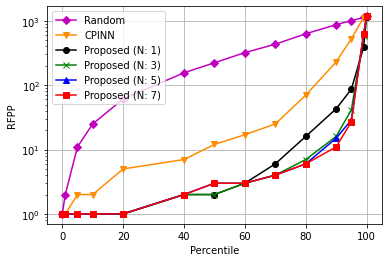

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
path='/content/drive/MyDrive/CPI_Data/'
perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]
####
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')
####Random_Average_perntile_Random1=np.load(path+'Random_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Random_Average_perntile_Random1,color='m',marker='D',label='Random')
####CPI-NN
#CPI_NN_Fold0=np.load(path+'fold0_CPI_NN_Average_perntile.npy')
CPI_NN_allfolds=np.load(path+'CPI_NN_Average_perntile.npy')
plt.plot(perntile_values,CPI_NN_allfolds,color='darkorange',marker='v',label='CPINN')#'indigo'
####
######
NegativeRatio=1
Average_perntile_Random1=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random1,color='k',marker='o',label='Proposed (N:{: .0f})'.format(NegativeRatio))
####
######
NegativeRatio=3
Average_perntile_Random3=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random3,color='g',marker='x',label='Proposed (N:{: .0f})'.format(NegativeRatio))
######
NegativeRatio=5
Average_perntile_Random5=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random5,color='b',marker='^',label='Proposed (N:{: .0f})'.format(NegativeRatio))
###
NegativeRatio=7
Average_perntile_Random7=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random7,color='r',marker='s',label='Proposed (N:{: .0f})'.format(NegativeRatio))
###
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()
plt.rcParams['savefig.dpi'] = 1000
plt.show()
fig .savefig(path+"RFPP.pdf", bbox_inches='tight')

In [ ]:
Random_Average_perntile_Random1

array([1.00000e+00, 2.00000e+00, 1.10000e+01, 2.50000e+01, 6.10000e+01,
       1.56000e+02, 2.23000e+02, 3.21000e+02, 4.33500e+02, 6.30000e+02,
       8.72000e+02, 1.00500e+03, 1.12955e+03, 1.17900e+03])

In [ ]:
CPI_NN_allfolds

array([1.00000e+00, 1.00000e+00, 2.00000e+00, 2.00000e+00, 5.00000e+00,
       7.00000e+00, 1.20000e+01, 1.70000e+01, 2.50000e+01, 7.00000e+01,
       2.30000e+02, 5.30300e+02, 1.11822e+03, 1.17700e+03])

In [ ]:
Average_perntile_Random1

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       2.0000e+00, 2.0000e+00, 3.0000e+00, 6.0000e+00, 1.6000e+01,
       4.3000e+01, 8.7000e+01, 3.8772e+02, 1.1370e+03])

In [ ]:
Average_perntile_Random3

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       2.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 7.0000e+00,
       1.6000e+01, 4.1650e+01, 5.8331e+02, 1.1760e+03])

In [ ]:
Average_perntile_Random5

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       2.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 6.0000e+00,
       1.5000e+01, 2.9000e+01, 6.1868e+02, 1.1740e+03])

In [ ]:
Average_perntile_Random7

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       2.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 6.0000e+00,
       1.1000e+01, 2.7000e+01, 6.2408e+02, 1.1790e+03])

In [ ]:
Average_perntile_05

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.8 ,  1.  ,  1.8 ,
        2.8 ,  4.8 ,  6.44, 17.7 , 95.6 ])

In [ ]:
Average_perntile_Random

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  1.   ,
        1.8  ,  3.16 ,  5.42 ,  9.65 , 24.476, 81.   ])

In [ ]:
Average_perntile_Random

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.7  ,
         1.   ,   2.   ,   3.   ,   4.68 ,   9.   ,  29.806, 105.4  ])

In [ ]:
import numpy as np
path='/content/drive/MyDrive/CPI_Data/'
NegativeRatio=5
Average_perntile_Random=np.load(path+'Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
#Average_perntile_001_NegativeRatio_3=np.load(path+'Average_perntile_0.01_NegativeRatio_3.npy')
Average_perntile_005_NegativeRatio_3=np.load(path+'Average_perntile_0.05_NegativeRatio_3.npy')
Average_perntile_Random_NegativeRatio_3=np.load(path+'Average_perntile_Random_NegativeRatio_3.npy')
Average_perntile_07_NegativeRatio_3=np.load(path+'Average_perntile_0.7_NegativeRatio_3.npy')
1/0
plt.plot(perntile_values,Average_perntile_005_NegativeRatio_1,color='b',marker='o',label='5fold_Alpha_0.05_NegtiveRatio_1')#0.005_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
#plt.plot(perntile_values,Average_perntile,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.plot(perntile_values,Average_perntile_001_NegativeRatio_1,color='r',marker='x',label='5fold_Alpha_0.01_NegtiveRatio_1')#5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.plot(perntile_values,Average_perntile_Random_NegativeRatio_1,color='g',marker='s',label='5fold_Alpha_Random_NegtiveRatio_1')
plt.plot(perntile_values,Average_perntile_07_NegativeRatio_1,color='m',marker='^',label='5fold_Alpha_0.7_NegtiveRatio_1')

plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()

FileNotFoundError: ignored

In [ ]:
perntile_values = [0,2,5,10,20,40,50,60,70,80,90,100]
perntile_list=[]
for p in perntile_values:
  perntile=[]
  for fold in range(len(RFPP_Folds)):
    perntile.append(np.percentile(RFPP_Folds[fold],p))
  perntile_list.append(perntile)
Average_perntile_07_NegativeRatio_1=np.mean(perntile_list, axis=1)
np.save(path+'Average_perntile_0.7_NegativeRatio_1.npy',Average_perntile_07_NegativeRatio_1)

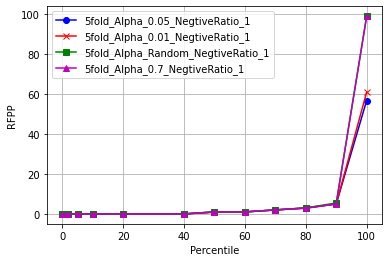

In [ ]:
Average_perntile_001_NegativeRatio_1=np.load(path+'Average_perntile_0.01_NegativeRatio_1.npy')
Average_perntile_005_NegativeRatio_1=np.load(path+'Average_perntile_005_NegativeRatio_1.npy')
Average_perntile_Random_NegativeRatio_1=np.load(path+'Average_perntile_Random_NegativeRatio_1.npy')
Average_perntile_07_NegativeRatio_1=np.load(path+'Average_perntile_0.7_NegativeRatio_1.npy')
plt.plot(perntile_values,Average_perntile_005_NegativeRatio_1,color='b',marker='o',label='5fold_Alpha_0.05_NegtiveRatio_1')#0.005_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
#plt.plot(perntile_values,Average_perntile,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.plot(perntile_values,Average_perntile_001_NegativeRatio_1,color='r',marker='x',label='5fold_Alpha_0.01_NegtiveRatio_1')#5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.plot(perntile_values,Average_perntile_Random_NegativeRatio_1,color='g',marker='s',label='5fold_Alpha_Random_NegtiveRatio_1')
plt.plot(perntile_values,Average_perntile_07_NegativeRatio_1,color='m',marker='^',label='5fold_Alpha_0.7_NegtiveRatio_1')

plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()

In [ ]:
Average_perntile_Random_NegativeRatio_1

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  2.  ,
        3.  ,  5.48, 99.  ])

In [ ]:
Average_perntile_07_NegativeRatio_1

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  2. ,  2.8,  5. ,
       99. ])

In [ ]:
Average_perntile_005_NegativeRatio_1

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  2.  ,
        3.  ,  4.96, 56.8 ])

In [ ]:
Average_perntile_001_NegativeRatio_1

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.8,  1. ,  2. ,  3. ,  5. ,
       61. ])

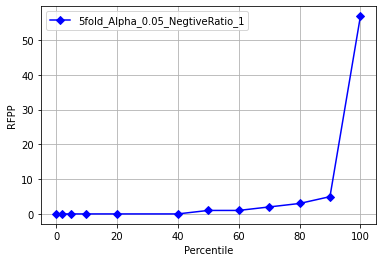

In [ ]:
perntile_values = [0,2,5,10,20,40,50,60,70,80,90,100]
perntile_list=[]
colors=['r','g','b']
for p in perntile_values:
  perntile=[]
  for fold in range(len(RFPP_Folds)):
    perntile.append(np.percentile(RFPP_Folds[fold],p))
  perntile_list.append(perntile)

Average_perntile_005_NegativeRatio_1=np.mean(perntile_list, axis=1)
np.save(path+'Average_perntile_005_NegativeRatio_1.npy',Average_perntile_005_NegativeRatio_1)
plt.plot(perntile_values,Average_perntile_005_NegativeRatio_1,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
#plt.plot(perntile_values,Average_perntile,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()

In [ ]:
Average_perntile

11.833333333333334

In [ ]:
import matplotlib.pyplot as plt

a = np.arange(4)
perntile = [0,2,5,10,20,40,50,60,70,80,90,100]
for interpolation, style in lines:
    ax.plot(
        p, np.percentile(a, p, interpolation=interpolation),
        label=interpolation, linestyle=style)
ax.set(
    title='Interpolation methods for list: ' + str(a),
    xlabel='Percentile',
    ylabel='List item returned',
    yticks=a)
ax.legend()
plt.show()